In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgbm
import structureboost as stb
import ml_insights as mli
from structureboost import log_loss
pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)

In [2]:
df=pd.read_csv('df_bp7.csv')
df

/tmp/ipykernel_92258/3635135713.py:1: DtypeWarning: Columns (13,14,15,19,85,87,159,198) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('df_bp7.csv')


,date,dblheader_code,day_of_week,team_v,league_v,game_no_v,team_h,league_h,game_no_h,runs_v,runs_h,outs_total,day_night,completion_info,forfeit_info,protest_info,ballpark_id,attendance,game_minutes,linescore_v,linescore_h,AB_v,H_v,2B_v,3B_v,HR_v,RBI_v,SH_v,SF_v,HBP_v,BB_v,IBB_v,SO_v,SB_v,CS_v,GIDP_v,CI_v,LOB_v,P_num_v,ERind_v,ERteam_v,WP_v,balk_v,PO_v,ASST_v,ERR_v,PB_v,DP_v,TP_v,AB_h,H_h,2B_h,3B_h,HR_h,RBI_h,SH_h,SF_h,HBP_h,BB_h,IBB_h,SO_h,SB_h,CS_h,GIDP_h,CI_h,LOB_h,P_num_h,ERind_h,ERteam_h,WP_h,balk_h,PO_h,ASST_h,ERR_h,PB_h,DP_h,TP_h,ump_HB_id,ump_HB_name,ump_1B_id,ump_1B_name,ump_2B_id,ump_2B_name,ump_3B_id,ump_3B_name,ump_LF_id,ump_LF_name,ump_RF_id,ump_RF_name,mgr_id_v,mgr_name_v,mgr_id_h,mgr_name_h,pitcher_id_w,pitcher_name_w,pitcher_id_l,pitcher_name_l,pitcher_id_s,pitcher_name_s,GWRBI_id,GWRBI_name,pitcher_start_id_v,pitcher_start_name_v,pitcher_start_id_h,pitcher_start_name_h,batter1_name_v,batter1_id_v,batter1_pos_v,batter2_name_v,batter2_id_v,batter2_pos_v,batter3_name_v,batter3_id_v,batter3_pos_v,batter4_name_v,batter4_id_v,batter4_pos_v,batter5_name_v,batter5_id_v,batter5_pos_v,batter6_name_v,batter6_id_v,batter6_pos_v,batter7_name_v,batter7_id_v,batter7_pos_v,batter8_name_v,batter8_id_v,batter8_pos_v,batter9_name_v,batter9_id_v,batter9_pos_v,batter1_name_h,batter1_id_h,batter1_pos_h,batter2_name_h,batter2_id_h,batter2_pos_h,batter3_name_h,batter3_id_h,batter3_pos_h,batter4_name_h,batter4_id_h,batter4_pos_h,batter5_name_h,batter5_id_h,batter5_pos_h,batter6_name_h,batter6_id_h,batter6_pos_h,batter7_name_h,batter7_id_h,batter7_pos_h,batter8_name_h,batter8_id_h,batter8_pos_h,batter9_name_h,batter9_id_h,batter9_pos_h,misc_info,acqui_info,season,run_diff,home_victory,run_total,date_dblhead,BATAVG_162_h,BATAVG_162_v,OBP_162_h,OBP_162_v,SLG_162_h,SLG_162_v,OBS_162_h,OBS_162_v,SB_162_h,SB_162_v,CS_162_h,CS_162_v,ERR_162_h,ERR_162_v,BATAVG_30_h,BATAVG_30_v,OBP_30_h,OBP_30_v,SLG_30_h,SLG_30_v,OBS_30_h,OBS_30_v,SB_30_h,SB_30_v,CS_30_h,CS_30_v,ERR_30_h,ERR_30_v,implied_prob_h,implied_prob_v,implied_prob_h_mid,over_under_line,over_under_result,Strt_GS_h,Strt_GS_v,Strt_IP_h,Strt_IP_v,Strt_H_h,Strt_H_v,Strt_BFP_h,Strt_BFP_v,Strt_HR_h,Strt_HR_v,Strt_R_h,Strt_R_v,Strt_ER_h,Strt_ER_v,Strt_BB_h,Strt_BB_v,Strt_IB_h,Strt_IB_v,Strt_SO_h,Strt_SO_v,Strt_SH_h,Strt_SH_v,Strt_SF_h,Strt_SF_v,Strt_WP_h,Strt_WP_v,Strt_HBP_h,Strt_HBP_v,Strt_BK_h,Strt_BK_v,Strt_2B_h,Strt_2B_v,Strt_3B_h,Strt_3B_v,Strt_IP_real_h,Strt_IP_real_v,Strt_rollsum_IP_real_10_h,Strt_rollsum_IP_real_10_v,Strt_rollsum_H_10_h,Strt_rollsum_H_10_v,Strt_rollsum_BFP_10_h,Strt_rollsum_BFP_10_v,Strt_rollsum_HR_10_h,Strt_rollsum_HR_10_v,Strt_rollsum_R_10_h,Strt_rollsum_R_10_v,Strt_rollsum_ER_10_h,Strt_rollsum_ER_10_v,Strt_rollsum_BB_10_h,Strt_rollsum_BB_10_v,Strt_rollsum_IB_10_h,Strt_rollsum_IB_10_v,Strt_rollsum_SO_10_h,Strt_rollsum_SO_10_v,Strt_rollsum_SH_10_h,Strt_rollsum_SH_10_v,Strt_rollsum_SF_10_h,Strt_rollsum_SF_10_v,Strt_rollsum_WP_10_h,Strt_rollsum_WP_10_v,Strt_rollsum_HBP_10_h,Strt_rollsum_HBP_10_v,Strt_rollsum_BK_10_h,Strt_rollsum_BK_10_v,Strt_rollsum_2B_10_h,Strt_rollsum_2B_10_v,Strt_rollsum_3B_10_h,Strt_rollsum_3B_10_v,Strt_rollsum_IP_real_35_h,Strt_rollsum_IP_real_35_v,Strt_rollsum_H_35_h,Strt_rollsum_H_35_v,Strt_rollsum_BFP_35_h,Strt_rollsum_BFP_35_v,Strt_rollsum_HR_35_h,Strt_rollsum_HR_35_v,Strt_rollsum_R_35_h,Strt_rollsum_R_35_v,Strt_rollsum_ER_35_h,Strt_rollsum_ER_35_v,Strt_rollsum_BB_35_h,Strt_rollsum_BB_35_v,Strt_rollsum_IB_35_h,Strt_rollsum_IB_35_v,Strt_rollsum_SO_35_h,Strt_rollsum_SO_35_v,Strt_rollsum_SH_35_h,Strt_rollsum_SH_35_v,Strt_rollsum_SF_35_h,Strt_rollsum_SF_35_v,Strt_rollsum_WP_35_h,Strt_rollsum_WP_35_v,Strt_rollsum_HBP_35_h,Strt_rollsum_HBP_35_v,Strt_rollsum_BK_35_h,Strt_rollsum_BK_35_v,Strt_rollsum_2B_35_h,Strt_rollsum_2B_35_v,Strt_rollsum_3B_35_h,Strt_rollsum_3B_35_v,Strt_rollsum_IP_real_75_h,Strt_rollsum_IP_real_75_v,Strt_rollsum_H_75_h,Strt_rollsum_H_75_v,Strt_rollsum_BFP_75_h,Strt_rollsum_BFP_75_v,Strt_rollsum_HR_75_h,Strt_rollsum_HR_75_v,Strt_rol

In [3]:
df = df[df.run_diff!=0]
df_train = df[(df.season>1980) & (df.season<=2018) & ~(df.OBP_162_h.isnull())]
df_valid = df[(df.season>=2019) & (df.season<=2020)]
df_test = df[df.season>=2021]
df.shape

(96215, 611)

In [4]:
hv_mean = df_train.home_victory.mean()
hv_mean

0.5391635426429241

In [5]:
np.array(df.columns)

array(['date', 'dblheader_code', 'day_of_week', 'team_v', 'league_v',
       'game_no_v', 'team_h', 'league_h', 'game_no_h', 'runs_v', 'runs_h',
       'outs_total', 'day_night', 'completion_info', 'forfeit_info',
       'protest_info', 'ballpark_id', 'attendance', 'game_minutes',
       'linescore_v', 'linescore_h', 'AB_v', 'H_v', '2B_v', '3B_v',
       'HR_v', 'RBI_v', 'SH_v', 'SF_v', 'HBP_v', 'BB_v', 'IBB_v', 'SO_v',
       'SB_v', 'CS_v', 'GIDP_v', 'CI_v', 'LOB_v', 'P_num_v', 'ERind_v',
       'ERteam_v', 'WP_v', 'balk_v', 'PO_v', 'ASST_v', 'ERR_v', 'PB_v',
       'DP_v', 'TP_v', 'AB_h', 'H_h', '2B_h', '3B_h', 'HR_h', 'RBI_h',
       'SH_h', 'SF_h', 'HBP_h', 'BB_h', 'IBB_h', 'SO_h', 'SB_h', 'CS_h',
       'GIDP_h', 'CI_h', 'LOB_h', 'P_num_h', 'ERind_h', 'ERteam_h',
       'WP_h', 'balk_h', 'PO_h', 'ASST_h', 'ERR_h', 'PB_h', 'DP_h',
       'TP_h', 'ump_HB_id', 'ump_HB_name', 'ump_1B_id', 'ump_1B_name',
       'ump_2B_id', 'ump_2B_name', 'ump_3B_id', 'ump_3B_name',
       'ump_LF_id'

In [6]:
target = 'home_victory'

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()

In [7]:
def try_features(feat_set, max_depth=2):
    target = 'home_victory'
    X_train = df_train.loc[:,feat_set]
    X_valid = df_valid.loc[:,feat_set]
    X_test = df_test.loc[:,feat_set]



    lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=max_depth)
    lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50)])
    
    preds_lgbm_test = lgbm1.predict_proba(X_test)[:,1]
    ll_test = log_loss(y_test, preds_lgbm_test)

    print(f'\nVegas probs: {log_loss(y_test,df_test.implied_prob_h_mid)} on test')
    print(f'model probs: {ll_test} on test')

    print(f'\nDifference: {ll_test - log_loss(y_test,df_test.implied_prob_h_mid)} on test')

    sv_lgbm = lgbm1.predict(X_test, pred_contrib=True)
    sv_lgbm = pd.DataFrame(sv_lgbm)
    sv_lgbm.columns = list(X_test.columns)+['Intercept']
    sv_vec = sv_lgbm.abs().mean().sort_values(ascending=False)
    print('\nAvg Shap Vals')
    
    print(sv_vec)
    out_dict={}
    out_dict['ll_test'] = ll_test
    out_dict['model'] = lgbm1
    out_dict['shap_val_avgs'] = sv_vec
    out_dict['preds_test'] = preds_lgbm_test
    return(out_dict)

In [8]:
features1 = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v',
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_H_BB_perc_35_h', 'Strt_H_BB_perc_35_v',
            'Strt_SO_perc_10_h', 'Strt_SO_perc_10_v',
]

In [9]:
d1 = try_features(features1)

[LightGBM] [Info] Number of positive: 46023, number of negative: 39337
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002744 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 85360, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539164 -> initscore=0.156976
[LightGBM] [Info] Start training from score 0.156976
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[418]	valid_0's binary_logloss: 0.675963

Vegas probs: 0.6675629431340582 on test
model probs: 0.6745067011428078 on test

Difference: 0.006943758008749579 on test

Avg Shap Vals
Intercept               0.158922
Strt_SO_perc_10_v       0.080200
Strt_SO_perc_10_h       0.073188
OBP_162_v               0.063135
Strt_WHIP_35_v          0.057388
OBP_162_h               0.056427
Strt_WHIP_35_h          0.051823

In [10]:
features2 = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v',
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_H_BB_perc_35_h', 'Strt_H_BB_perc_35_v',
            'Strt_SO_perc_10_h', 'Strt_SO_perc_10_v',
            'Bpen_WHIP_35_h','Bpen_WHIP_35_v',
            'Bpen_TB_BB_perc_35_h', 'Bpen_TB_BB_perc_35_v',
            'Bpen_H_BB_perc_35_h', 'Bpen_H_BB_perc_35_v',
            'Bpen_SO_perc_35_h', 'Bpen_SO_perc_35_v',
]

In [11]:
d2 = try_features(features2)

[LightGBM] [Info] Number of positive: 46023, number of negative: 39337
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 85360, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539164 -> initscore=0.156976
[LightGBM] [Info] Start training from score 0.156976
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[541]	valid_0's binary_logloss: 0.674127

Vegas probs: 0.6675629431340582 on test
model probs: 0.6723202148241308 on test

Difference: 0.004757271690072673 on test

Avg Shap Vals
Intercept               0.159181
Strt_SO_perc_10_h       0.081251
Strt_SO_perc_10_v       0.080950
OBP_162_v               0.062270
Strt_WHIP_35_v          0.054049
Strt_WHIP_35_h          0.053166
OBP_162_h               0.051116

In [12]:
features3 = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v',
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_H_BB_perc_35_h', 'Strt_H_BB_perc_35_v',
            'Strt_SO_perc_10_h', 'Strt_SO_perc_10_v',
            'Bpen_WHIP_75_h','Bpen_WHIP_75_v',
            'Bpen_TB_BB_perc_75_h', 'Bpen_TB_BB_perc_75_v',
            'Bpen_H_BB_perc_75_h', 'Bpen_H_BB_perc_75_v',
            'Bpen_SO_perc_75_h', 'Bpen_SO_perc_75_v',
            'Bpen_WHIP_35_h','Bpen_WHIP_35_v',
            'Bpen_TB_BB_perc_35_h', 'Bpen_TB_BB_perc_35_v',
            'Bpen_H_BB_perc_35_h', 'Bpen_H_BB_perc_35_v',
            'Bpen_SO_perc_35_h', 'Bpen_SO_perc_35_v',
            'Bpen_WHIP_10_h','Bpen_WHIP_10_v',
            'Bpen_TB_BB_perc_10_h', 'Bpen_TB_BB_perc_10_v',
            'Bpen_H_BB_perc_10_h', 'Bpen_H_BB_perc_10_v',
            'Bpen_SO_perc_10_h', 'Bpen_SO_perc_10_v',
]

In [13]:
d3 = try_features(features3, max_depth=2)

[LightGBM] [Info] Number of positive: 46023, number of negative: 39337
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9180
[LightGBM] [Info] Number of data points in the train set: 85360, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539164 -> initscore=0.156976
[LightGBM] [Info] Start training from score 0.156976
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[603]	valid_0's binary_logloss: 0.672806

Vegas probs: 0.6675629431340582 on test
model probs: 0.6714934504802158 on test

Difference: 0.00393050734615763 on test

Avg Shap Vals
Intercept               0.159327
Strt_SO_perc_10_h       0.079810
Strt_SO_perc_10_v       0.079673
OBP_162_v               0.062744
Strt_WHIP_35_v          0.053249
Strt_WHIP_35_h          0.052227
OBP_162_h               0.049028


In [14]:
features4 = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v',
            'Strt_WHIP_75_h','Strt_WHIP_75_v',
            'Strt_TB_BB_perc_75_h', 'Strt_TB_BB_perc_75_v',
            'Strt_H_BB_perc_75_h', 'Strt_H_BB_perc_75_v',
            'Strt_SO_perc_75_h', 'Strt_SO_perc_75_v',
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_H_BB_perc_35_h', 'Strt_H_BB_perc_35_v',
            'Strt_SO_perc_35_h', 'Strt_SO_perc_35_v',
            'Strt_WHIP_10_h','Strt_WHIP_10_v',
            'Strt_TB_BB_perc_10_h', 'Strt_TB_BB_perc_10_v',
            'Strt_H_BB_perc_10_h', 'Strt_H_BB_perc_10_v',
            'Strt_SO_perc_10_h', 'Strt_SO_perc_10_v',
            'Bpen_WHIP_75_h','Bpen_WHIP_75_v',
            'Bpen_TB_BB_perc_75_h', 'Bpen_TB_BB_perc_75_v',
            'Bpen_H_BB_perc_75_h', 'Bpen_H_BB_perc_75_v',
            'Bpen_SO_perc_75_h', 'Bpen_SO_perc_75_v',
            'Bpen_WHIP_35_h','Bpen_WHIP_35_v',
            'Bpen_TB_BB_perc_35_h', 'Bpen_TB_BB_perc_35_v',
            'Bpen_H_BB_perc_35_h', 'Bpen_H_BB_perc_35_v',
            'Bpen_SO_perc_35_h', 'Bpen_SO_perc_35_v',
            'Bpen_WHIP_10_h','Bpen_WHIP_10_v',
            'Bpen_TB_BB_perc_10_h', 'Bpen_TB_BB_perc_10_v',
            'Bpen_H_BB_perc_10_h', 'Bpen_H_BB_perc_10_v',
            'Bpen_SO_perc_10_h', 'Bpen_SO_perc_10_v',
]


In [15]:
d4 = try_features(features4)

[LightGBM] [Info] Number of positive: 46023, number of negative: 39337
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13260
[LightGBM] [Info] Number of data points in the train set: 85360, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539164 -> initscore=0.156976
[LightGBM] [Info] Start training from score 0.156976
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[698]	valid_0's binary_logloss: 0.672641

Vegas probs: 0.6675629431340582 on test
model probs: 0.6718433797666616 on test

Difference: 0.004280436632603468 on test

Avg Shap Vals
Intercept               0.159660
OBP_162_v               0.062651
Strt_SO_perc_10_h       0.053825
OBP_162_h               0.047227
Strt_SO_perc_10_v       0.047090
Strt_H_BB_perc_75_h     0.043097
SLG_162_h               0.04247

In [16]:
features5 = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v',
             'ERR_162_h', 'ERR_162_v',
             'SB_162_h', 'SB_162_v',
             'CS_162_h', 'CS_162_v',
             
             
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_H_BB_perc_35_h', 'Strt_H_BB_perc_35_v',
            'Strt_SO_perc_10_h', 'Strt_SO_perc_10_v',
            'Bpen_WHIP_75_h','Bpen_WHIP_75_v',
            'Bpen_TB_BB_perc_75_h', 'Bpen_TB_BB_perc_75_v',
            'Bpen_H_BB_perc_75_h', 'Bpen_H_BB_perc_75_v',
            'Bpen_SO_perc_75_h', 'Bpen_SO_perc_75_v',
            'Bpen_WHIP_35_h','Bpen_WHIP_35_v',
            'Bpen_TB_BB_perc_35_h', 'Bpen_TB_BB_perc_35_v',
            'Bpen_H_BB_perc_35_h', 'Bpen_H_BB_perc_35_v',
            'Bpen_SO_perc_35_h', 'Bpen_SO_perc_35_v',
            'Bpen_WHIP_10_h','Bpen_WHIP_10_v',
            'Bpen_TB_BB_perc_10_h', 'Bpen_TB_BB_perc_10_v',
            'Bpen_H_BB_perc_10_h', 'Bpen_H_BB_perc_10_v',
            'Bpen_SO_perc_10_h', 'Bpen_SO_perc_10_v',
]

In [17]:
d5 = try_features(features5)

[LightGBM] [Info] Number of positive: 46023, number of negative: 39337
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10217
[LightGBM] [Info] Number of data points in the train set: 85360, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539164 -> initscore=0.156976
[LightGBM] [Info] Start training from score 0.156976
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[636]	valid_0's binary_logloss: 0.673272

Vegas probs: 0.6675629431340582 on test
model probs: 0.671772404309157 on test

Difference: 0.004209461175098794 on test

Avg Shap Vals
Intercept               0.159319
Strt_SO_perc_10_h       0.080163
Strt_SO_perc_10_v       0.079937
OBP_162_v               0.059039
Strt_WHIP_35_v          0.052506
Strt_WHIP_35_h          0.051786
OBP_162_h               0.047760

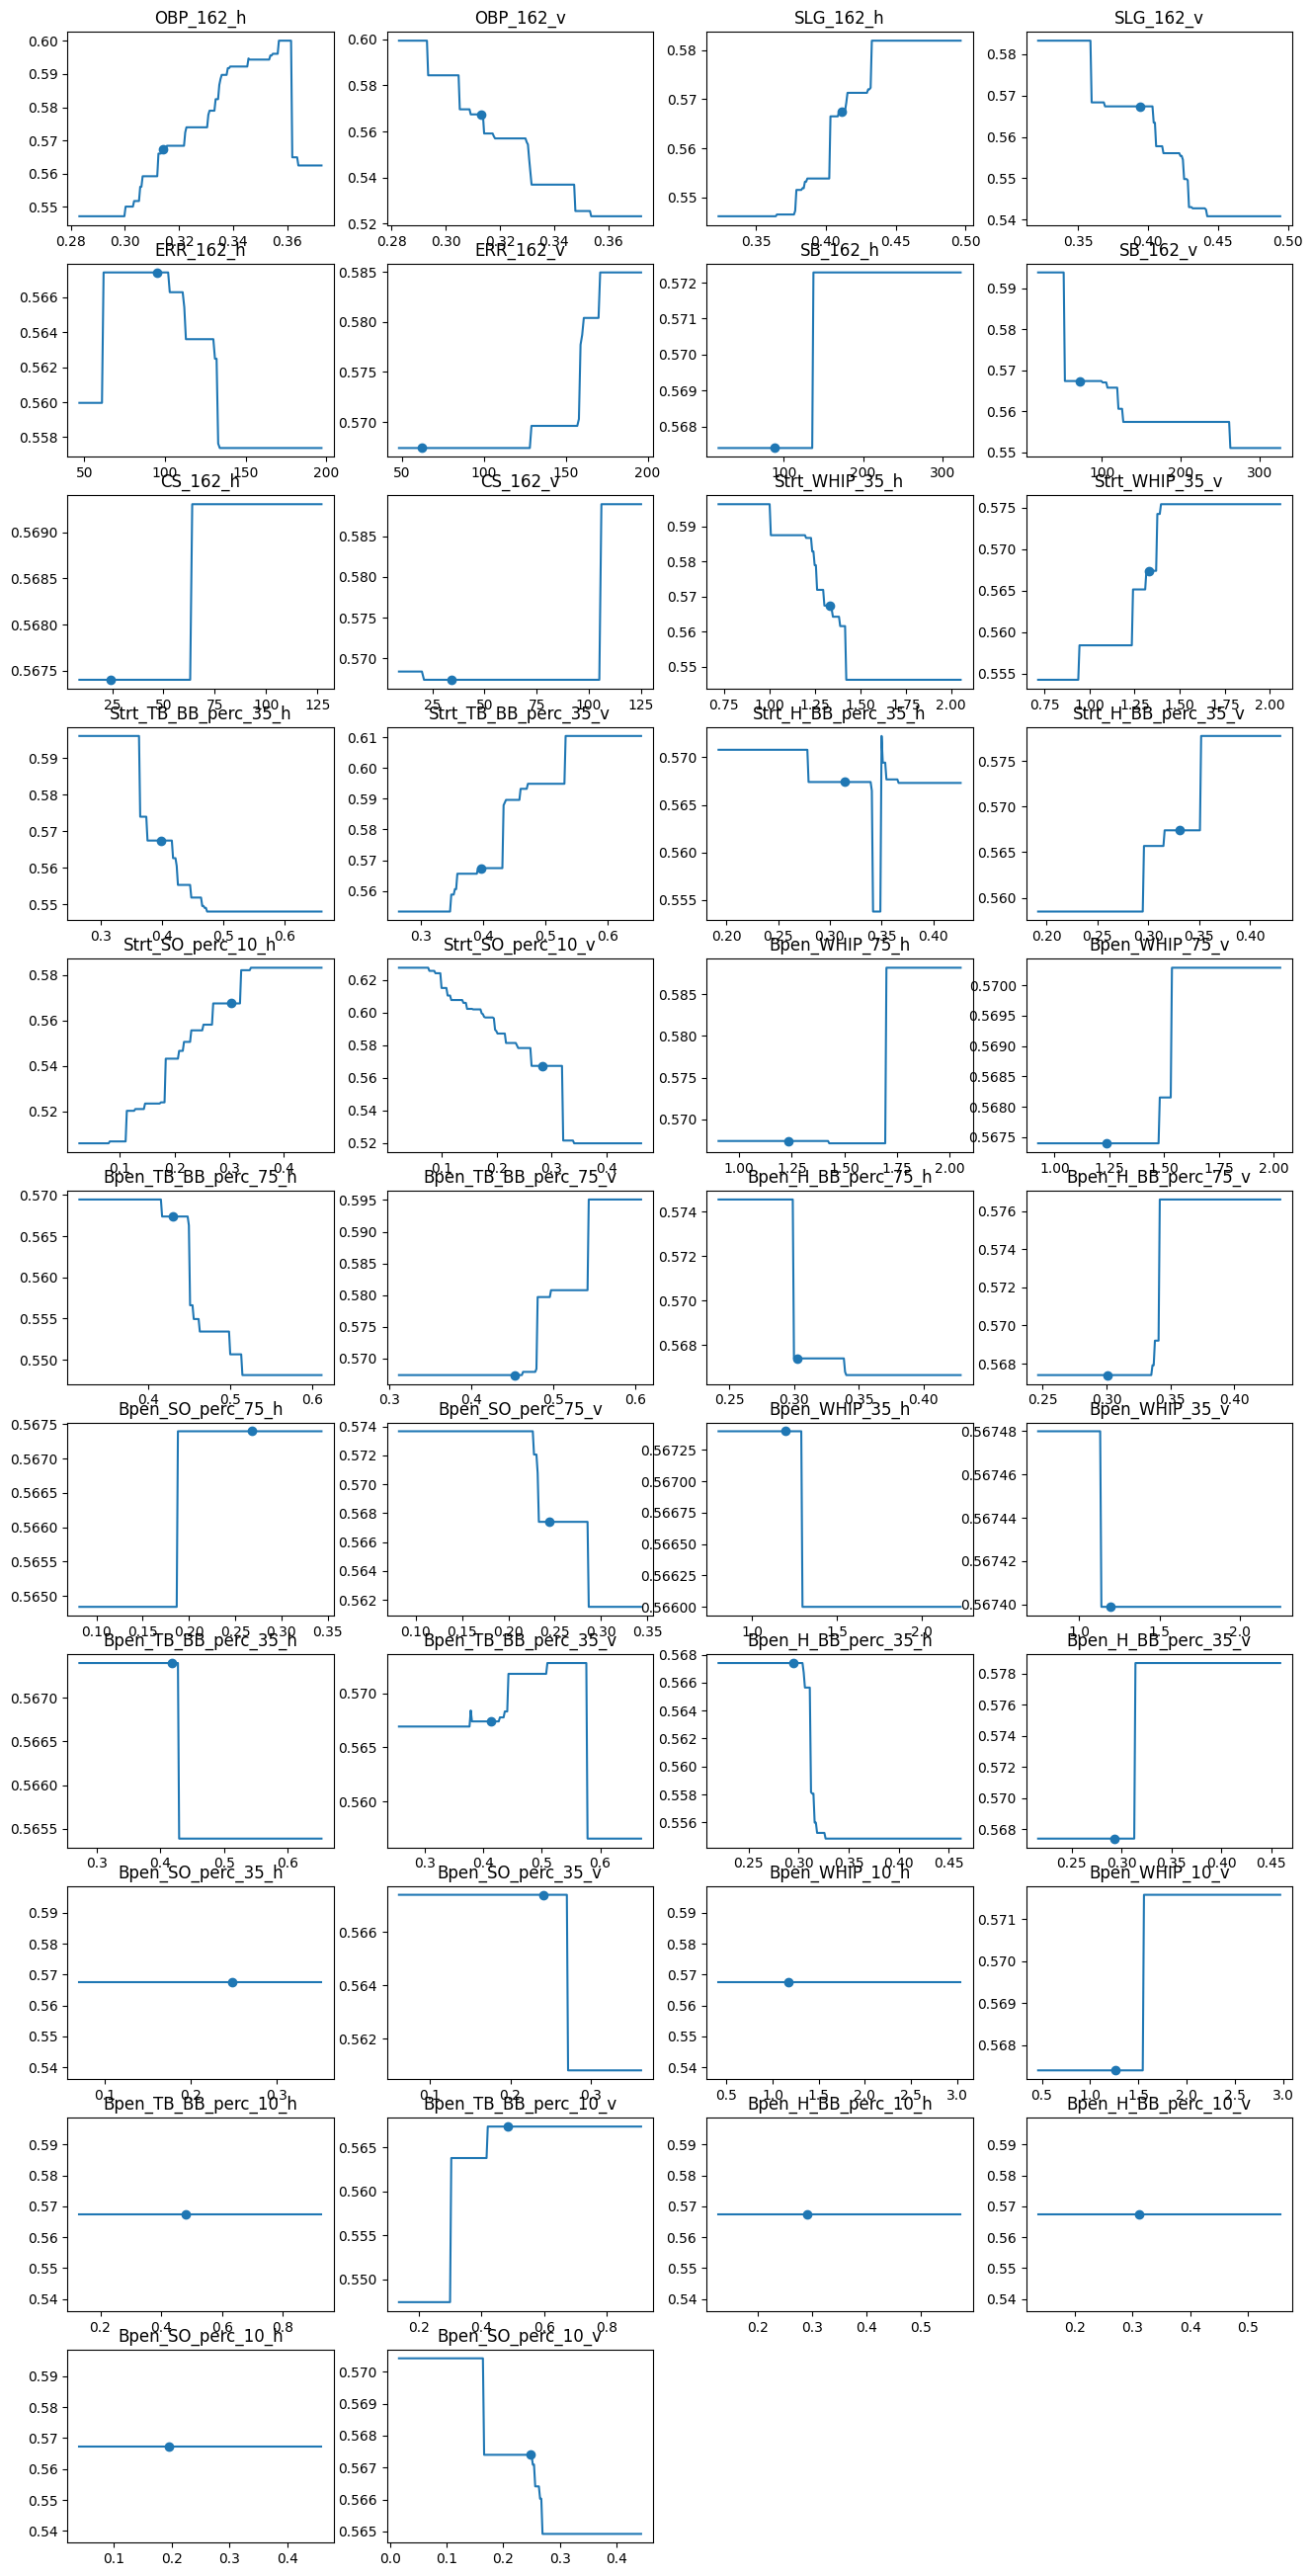

In [19]:
rd = mli.get_range_dict(df_train)
plot_pts = df_test.loc[:,features5].sample(1, random_state=42)
mli.ice_plot(d5['model'], plot_pts, features5, rd, plots_per_row=4)

In [21]:
# Put something for stolen bases that puts sb and cs cols together
df = df.copy()
df['SBadj_162_h'] = df['SB_162_h'] - 3*df['CS_162_h']
df['SBadj_162_v'] = df['SB_162_v'] - 3*df['CS_162_v']

In [22]:
df_train = df[(df.season>1980) & (df.season<=2018) & ~(df.OBP_162_h.isnull())]
df_valid = df[(df.season>=2019) & (df.season<=2020)]
df_test = df[df.season>=2021]
df_test_val = df[df.season>=2019]

In [23]:
features6  = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v',
             'ERR_162_h', 'ERR_162_v',
             # 'SB_162_h', 'SB_162_v',
             # 'CS_162_h', 'CS_162_v',
             'SBadj_162_h','SBadj_162_v',
             
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_H_BB_perc_35_h', 'Strt_H_BB_perc_35_v',
            'Strt_SO_perc_10_h', 'Strt_SO_perc_10_v',
            'Bpen_WHIP_75_h','Bpen_WHIP_75_v',
            'Bpen_TB_BB_perc_75_h', 'Bpen_TB_BB_perc_75_v',
            'Bpen_H_BB_perc_75_h', 'Bpen_H_BB_perc_75_v',
            'Bpen_SO_perc_75_h', 'Bpen_SO_perc_75_v',
            'Bpen_WHIP_35_h','Bpen_WHIP_35_v',
            'Bpen_TB_BB_perc_35_h', 'Bpen_TB_BB_perc_35_v',
            'Bpen_H_BB_perc_35_h', 'Bpen_H_BB_perc_35_v',
            'Bpen_SO_perc_35_h', 'Bpen_SO_perc_35_v',
            'Bpen_WHIP_10_h','Bpen_WHIP_10_v',
            'Bpen_TB_BB_perc_10_h', 'Bpen_TB_BB_perc_10_v',
            'Bpen_H_BB_perc_10_h', 'Bpen_H_BB_perc_10_v',
            'Bpen_SO_perc_10_h', 'Bpen_SO_perc_10_v',
              
]

In [24]:
d6 = try_features(features6)

[LightGBM] [Info] Number of positive: 46023, number of negative: 39337
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9986
[LightGBM] [Info] Number of data points in the train set: 85360, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539164 -> initscore=0.156976
[LightGBM] [Info] Start training from score 0.156976
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[724]	valid_0's binary_logloss: 0.673007

Vegas probs: 0.6675629431340582 on test
model probs: 0.6716823021988269 on test

Difference: 0.0041193590647686795 on test

Avg Shap Vals
Intercept               0.159480
Strt_SO_perc_10_v       0.083621
Strt_SO_perc_10_h       0.082149
OBP_162_v               0.061263
Strt_WHIP_35_h          0.052591
Strt_WHIP_35_v          0.051548
OBP_162_h               0.04893

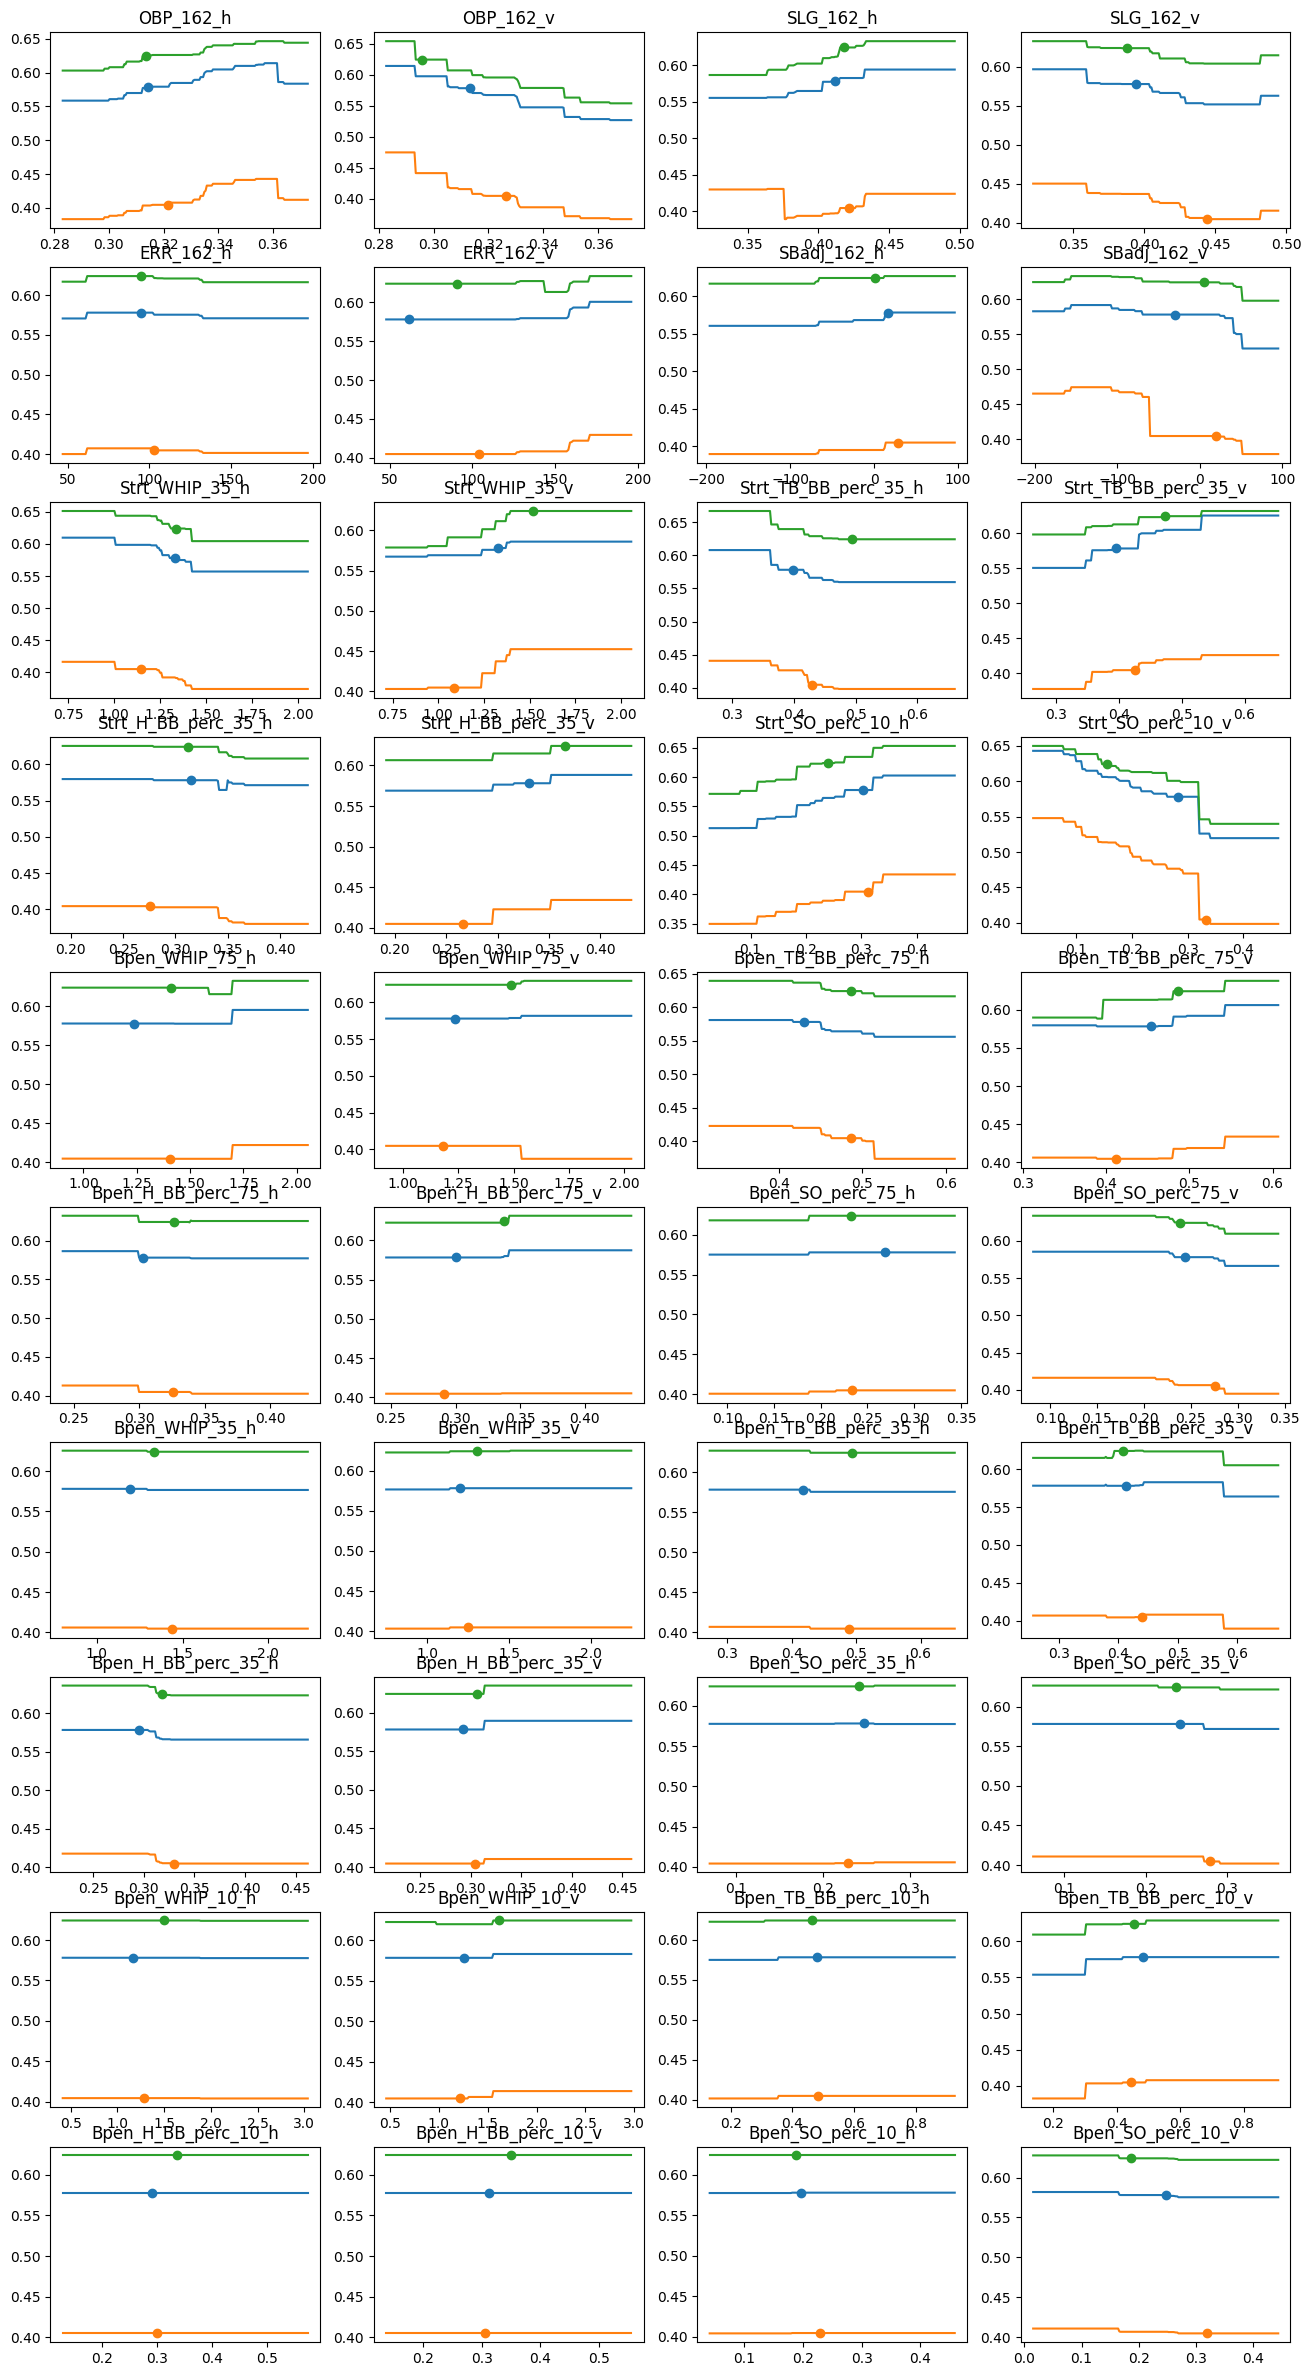

In [25]:
rd = mli.get_range_dict(df_train)
plot_pts = df_test.loc[:,features6].sample(3, random_state=42)
mli.ice_plot(d6['model'], plot_pts, features6, rd, plots_per_row=4)

# Model Analysis

- performing some analysis on our most best model, model 3

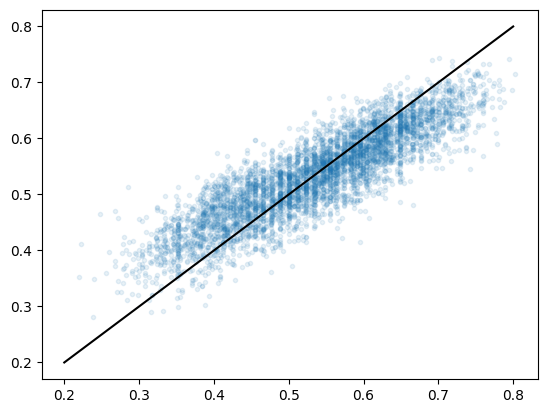

In [26]:
plt.scatter(df_test.implied_prob_h_mid, d3['preds_test'], marker='.', alpha=.1)
plt.plot([.2,.8],[.2,.8], color='k')

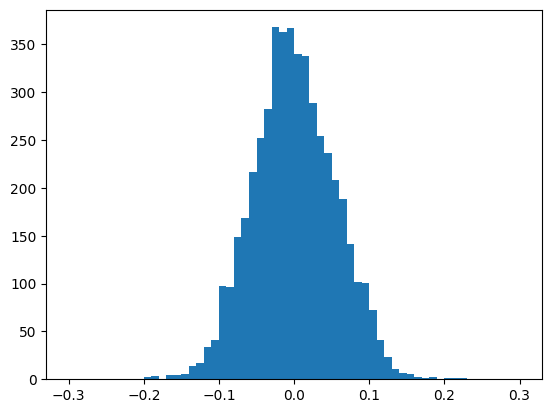

In [27]:
test_disc = d3['preds_test'] - df_test.implied_prob_h_mid
plt.hist(test_disc, bins=np.linspace(-.3,.3,61));

In [28]:
## let's compare performance on the cases with a large discrepancy
mask = (np.abs(test_disc))>.1
log_loss(y_test[mask], d3['preds_test'][mask]), log_loss(y_test[mask], df_test.implied_prob_h_mid[mask])

(0.673537460220991, 0.648058657571374)

In [29]:
log_loss(y_test[~mask], d3['preds_test'][~mask]), log_loss(y_test[~mask], df_test.implied_prob_h_mid[~mask])

(0.6713620850812144, 0.6688164539192888)

# Conclusions
- Still about 40 bps away from Vegas probabilities (down from ~70)
- When our model and Vegas "disagree", Vegas is generally right!
- We are running out of "big wins"
    - Features based on actual starting lineup
    - Fielding
    - Lefty vs Righty analysis

# Next Steps

- get batter data
- make features based on lineup
- analyze runs scored (o/u)
    - model for runs may help with moneyline model